In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [2]:
# Install all required dependencies
!pip install ultralytics opencv-python-headless torch torchvision scipy scikit-learn matplotlib
!apt-get update && apt-get install -y libgl1-mesa-glx

import cv2
import torch
import torchvision.transforms as transforms
from ultralytics import YOLO
import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import os

class PlayerReIDPipeline:
    def __init__(self, model_path):
        self.model = YOLO(model_path)
        self.broadcast_detections = []
        self.tacticam_detections = []
        self.broadcast_frames = []
        self.tacticam_frames = []

        # Print model classes for debugging
        print("🏷️  Model classes:", self.model.names)

    def safe_extract_center(self, center):
        """Safely extract center coordinates"""
        if isinstance(center, (list, tuple, np.ndarray)):
            flat_center = np.array(center).flatten()
            if len(flat_center) >= 2:
                return float(flat_center[0]), float(flat_center[1])
            else:
                return 0.0, 0.0
        else:
            return float(center), float(center)

    def extract_frames(self, video_path, max_frames=30):
        """Extract frames from video"""
        if not os.path.exists(video_path):
            print(f"❌ Video file not found: {video_path}")
            return []

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"❌ Cannot open video: {video_path}")
            return []

        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        if total_frames == 0:
            print(f"❌ No frames found in video: {video_path}")
            cap.release()
            return []

        # Sample frames from middle portion
        start_frame = total_frames // 4
        end_frame = 3 * total_frames // 4
        step = max(1, (end_frame - start_frame) // max_frames)

        print(f"📹 Processing {video_path}: sampling frames {start_frame} to {end_frame}, step {step}")

        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        current_frame = start_frame

        while current_frame < end_frame and len(frames) < max_frames:
            ret, frame = cap.read()
            if not ret:
                break

            if (current_frame - start_frame) % step == 0:
                frames.append(frame)

            current_frame += 1

        cap.release()
        print(f"✅ Extracted {len(frames)} frames from {video_path}")
        return frames

    def detect_all_objects(self, frames, video_name=""):
        """Detect ALL objects with very low confidence threshold"""
        if not frames:
            print(f"❌ No frames to process for {video_name}")
            return []

        all_detections = []
        class_counts = {}

        print(f"🔍 Detecting ALL objects in {len(frames)} frames from {video_name}...")

        for i, frame in enumerate(frames):
            results = self.model(frame, verbose=False)
            frame_detections = []

            for result in results:
                boxes = result.boxes
                if boxes is not None:
                    for box in boxes:
                        cls = int(box.cls)
                        conf = float(box.conf.cpu().numpy().item())
                        class_name = self.model.names.get(cls, f"class_{cls}")

                        # Count all classes
                        if class_name not in class_counts:
                            class_counts[class_name] = 0
                        class_counts[class_name] += 1

                        # Accept ALL classes with very low confidence threshold
                        if conf > 0.1:  # Very low threshold to catch everything
                            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()

                            center_x = float((x1 + x2) / 2)
                            center_y = float((y1 + y2) / 2)

                            frame_detections.append({
                                'bbox': [float(x1), float(y1), float(x2), float(y2)],
                                'confidence': conf,
                                'center': [center_x, center_y],
                                'class': cls,
                                'class_name': class_name
                            })

            all_detections.append(frame_detections)

            # Debug: Print detection info for first few frames
            if i < 3:
                print(f"   Frame {i}: {len(frame_detections)} detections")
                for det in frame_detections[:5]:  # Show first 5 detections
                    print(f"     - {det['class_name']} (conf: {det['confidence']:.2f})")

        # Print class distribution
        print(f"📊 Class distribution for {video_name}:")
        for class_name, count in sorted(class_counts.items()):
            print(f"   {class_name}: {count}")

        total_detections = sum(len(dets) for dets in all_detections)
        print(f"✅ Detection complete for {video_name}: {total_detections} total detections")
        return all_detections

    def extract_visual_features(self, frame, bbox):
        """Extract visual features from detection crop"""
        x1, y1, x2, y2 = map(int, bbox)
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(frame.shape[1], x2), min(frame.shape[0], y2)

        crop = frame[y1:y2, x1:x2]

        if crop.size == 0 or crop.shape[0] < 5 or crop.shape[1] < 5:
            return np.zeros(26, dtype=np.float32)  # Reduced feature size

        # Simplified color histogram features
        hist_b = cv2.calcHist([crop], [0], None, [8], [0, 256])
        hist_g = cv2.calcHist([crop], [1], None, [8], [0, 256])
        hist_r = cv2.calcHist([crop], [2], None, [8], [0, 256])

        hist_b = hist_b.flatten() / (hist_b.sum() + 1e-7)
        hist_g = hist_g.flatten() / (hist_g.sum() + 1e-7)
        hist_r = hist_r.flatten() / (hist_r.sum() + 1e-7)

        color_features = np.concatenate([hist_b, hist_g, hist_r])

        # Spatial features
        height, width = crop.shape[:2]
        aspect_ratio = width / (height + 1e-7)
        area = width * height
        spatial_features = np.array([aspect_ratio, area / 10000], dtype=np.float32)

        return np.concatenate([color_features.astype(np.float32), spatial_features])

    def extract_features(self, detections, frames):
        """Extract comprehensive features for all detections"""
        all_features = []

        for frame_idx, (frame_dets, frame) in enumerate(zip(detections, frames)):
            frame_features = []

            for det in frame_dets:
                visual_feat = self.extract_visual_features(frame, det['bbox'])

                x1, y1, x2, y2 = [float(coord) for coord in det['bbox']]
                h, w = frame.shape[:2]

                cx, cy = self.safe_extract_center(det['center'])

                spatial_feat = np.array([
                    cx / w,
                    cy / h,
                    (x2 - x1) / w,
                    (y2 - y1) / h,
                    float(det['confidence']),
                    float(det.get('class', 0))
                ], dtype=np.float32)

                combined_feat = np.concatenate([visual_feat, spatial_feat])
                frame_features.append(combined_feat)

            all_features.append(frame_features)

        return all_features

    def compute_similarity_matrix(self, features1, features2):
        """Compute similarity matrix"""
        if len(features1) == 0 or len(features2) == 0:
            return np.array([])

        feat1_array = np.array(features1)
        feat2_array = np.array(features2)

        similarity_matrix = cosine_similarity(feat1_array, feat2_array)

        # Boost similarity for same class
        for i, f1 in enumerate(feat1_array):
            for j, f2 in enumerate(feat2_array):
                if f1[-1] == f2[-1]:  # Same class
                    similarity_matrix[i, j] *= 1.5

        return similarity_matrix

    def match_objects_hungarian(self, similarity_matrix):
        """Match objects using Hungarian algorithm"""
        if similarity_matrix.size == 0:
            return []

        cost_matrix = -similarity_matrix
        row_indices, col_indices = linear_sum_assignment(cost_matrix)

        matches = []
        for row, col in zip(row_indices, col_indices):
            if similarity_matrix[row, col] > 0.02:  # Very low threshold
                matches.append((row, col, similarity_matrix[row, col]))

        return matches

    def process_videos(self, broadcast_path, tacticam_path):
        """Main processing function"""
        print("🚀 Starting cross-camera object re-identification...")

        # Extract frames
        self.broadcast_frames = self.extract_frames(broadcast_path)
        self.tacticam_frames = self.extract_frames(tacticam_path)

        if not self.broadcast_frames or not self.tacticam_frames:
            print("❌ Failed to extract frames from one or both videos")
            return []

        # Detect all objects
        self.broadcast_detections = self.detect_all_objects(self.broadcast_frames, "broadcast")
        self.tacticam_detections = self.detect_all_objects(self.tacticam_frames, "tacticam")

        # Check for overlapping frames
        frames_with_both = 0
        for i in range(min(len(self.broadcast_detections), len(self.tacticam_detections))):
            b_count = len(self.broadcast_detections[i])
            t_count = len(self.tacticam_detections[i])
            if b_count > 0 and t_count > 0:
                frames_with_both += 1
                if frames_with_both <= 5:  # Show first 5 frames with detections
                    print(f"📍 Frame {i}: Broadcast={b_count}, Tacticam={t_count}")

        print(f"📊 Frames with detections in both cameras: {frames_with_both}")

        # Extract features
        print("🔧 Extracting features...")
        broadcast_features = self.extract_features(self.broadcast_detections, self.broadcast_frames)
        tacticam_features = self.extract_features(self.tacticam_detections, self.tacticam_frames)

        # Match objects
        print("🔗 Matching objects across cameras...")
        all_matches = []
        total_matches = 0

        for frame_idx in range(min(len(broadcast_features), len(tacticam_features))):
            broadcast_count = len(broadcast_features[frame_idx])
            tacticam_count = len(tacticam_features[frame_idx])

            if broadcast_count > 0 and tacticam_count > 0:
                similarity_matrix = self.compute_similarity_matrix(
                    broadcast_features[frame_idx],
                    tacticam_features[frame_idx]
                )

                matches = self.match_objects_hungarian(similarity_matrix)
                total_matches += len(matches)

                all_matches.append({
                    'frame': frame_idx,
                    'matches': matches,
                    'broadcast_count': broadcast_count,
                    'tacticam_count': tacticam_count
                })

                if matches and len(all_matches) <= 5:  # Show first 5 frames with matches
                    print(f"✅ Frame {frame_idx}: {len(matches)} matches found")

        print(f"🎉 Processing complete! Found {total_matches} total matches across {len(all_matches)} frames")
        return all_matches

def create_comprehensive_output_video(pipeline, results, broadcast_video_path, tacticam_video_path, output_path='all_classes_output.mp4'):
    """Create output video showing ALL detected classes and matches"""
    if not results:
        print("❌ No results to create video output")
        return False

    print(f"🎬 Creating comprehensive output video: {output_path}")

    # Get video properties
    sample_frame = pipeline.broadcast_frames[0]
    height, width = sample_frame.shape[:2]
    fps = 3  # Slower FPS for better viewing

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width*2, height))

    if not out.isOpened():
        print("❌ Failed to create video writer")
        return False

    # Different colors for different classes
    class_colors = {
        'player': (0, 255, 0),      # Green
        'goalkeeper': (255, 0, 0),   # Red
        'referee': (0, 0, 255),      # Blue
        'ball': (255, 255, 0),       # Yellow
        'person': (255, 0, 255),     # Magenta
    }

    match_colors = [(0, 255, 255), (255, 165, 0), (128, 0, 128), (0, 128, 0),
                   (128, 128, 0), (255, 192, 203), (165, 42, 42), (0, 255, 127)]

    frames_written = 0

    for result in results:
        frame_idx = result['frame']

        if frame_idx >= len(pipeline.broadcast_frames) or frame_idx >= len(pipeline.tacticam_frames):
            continue

        frame_b = pipeline.broadcast_frames[frame_idx].copy()
        frame_t = pipeline.tacticam_frames[frame_idx].copy()

        broadcast_dets = pipeline.broadcast_detections[frame_idx]
        tacticam_dets = pipeline.tacticam_detections[frame_idx]

        # Draw ALL detections with class-specific colors
        for i, det in enumerate(broadcast_dets):
            bbox = det['bbox']
            x1, y1, x2, y2 = map(int, bbox)
            class_name = det['class_name']
            conf = det['confidence']

            # Get color for this class
            color = class_colors.get(class_name, (128, 128, 128))  # Default gray

            cv2.rectangle(frame_b, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame_b, f'{class_name}({conf:.2f})', (x1, y1-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

        for i, det in enumerate(tacticam_dets):
            bbox = det['bbox']
            x1, y1, x2, y2 = map(int, bbox)
            class_name = det['class_name']
            conf = det['confidence']

            # Get color for this class
            color = class_colors.get(class_name, (128, 128, 128))  # Default gray

            cv2.rectangle(frame_t, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame_t, f'{class_name}({conf:.2f})', (x1, y1-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

        # Draw matches with bright colors
        matches = result['matches']
        for match_idx, (b_idx, t_idx, sim) in enumerate(matches):
            match_color = match_colors[match_idx % len(match_colors)]

            # Highlight matched objects
            if b_idx < len(broadcast_dets):
                bbox = broadcast_dets[b_idx]['bbox']
                x1, y1, x2, y2 = map(int, bbox)
                cv2.rectangle(frame_b, (x1, y1), (x2, y2), match_color, 4)
                cv2.putText(frame_b, f'MATCH{match_idx}', (x1, y2+20),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, match_color, 2)

            if t_idx < len(tacticam_dets):
                bbox = tacticam_dets[t_idx]['bbox']
                x1, y1, x2, y2 = map(int, bbox)
                cv2.rectangle(frame_t, (x1, y1), (x2, y2), match_color, 4)
                cv2.putText(frame_t, f'MATCH{match_idx}({sim:.2f})', (x1, y2+20),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, match_color, 2)

        # Create combined frame
        combined_frame = np.zeros((height, width*2, 3), dtype=np.uint8)
        combined_frame[:, :width, :] = frame_b
        combined_frame[:, width:, :] = frame_t

        # Add comprehensive frame info
        cv2.putText(combined_frame, f'Frame: {frame_idx} | Matches: {len(matches)}', (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(combined_frame, f'Broadcast ({len(broadcast_dets)} objects)', (10, height-50),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        cv2.putText(combined_frame, f'Tacticam ({len(tacticam_dets)} objects)', (width + 10, height-50),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

        # Add legend
        legend_y = height - 20
        for i, (class_name, color) in enumerate(class_colors.items()):
            cv2.putText(combined_frame, class_name, (10 + i*100, legend_y),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

        out.write(combined_frame)
        frames_written += 1

        if frames_written % 5 == 0:
            print(f"   Written {frames_written} frames...")

    out.release()

    if os.path.exists(output_path):
        file_size = os.path.getsize(output_path)
        print(f"✅ Video created: {output_path} ({file_size} bytes, {frames_written} frames)")
        return True
    else:
        print("❌ Failed to create output video file")
        return False

# Run the comprehensive pipeline
print("🎯 Starting comprehensive object detection and matching pipeline...")

pipeline = PlayerReIDPipeline('/content/best.pt')
results = pipeline.process_videos('/content/broadcast.mp4', '/content/tacticam.mp4')

if results:
    print("\n📊 Comprehensive Match Results:")
    for i, result in enumerate(results[:10]):  # Show first 10 results
        print(f"Frame {result['frame']}: {len(result['matches'])} matches found")
        if result['matches']:
            for j, match in enumerate(result['matches'][:3]):  # Show first 3 matches per frame
                print(f"  Match {j}: Object {match[0]} -> Object {match[1]} (similarity: {match[2]:.3f})")

    # Create comprehensive output video
    success = create_comprehensive_output_video(
        pipeline, results,
        '/content/broadcast.mp4', '/content/tacticam.mp4',
        '/content/all_classes_comprehensive_output.mp4'
    )

    if success:
        print("\n🎉 Comprehensive pipeline completed successfully!")
        print("📥 Download 'all_classes_comprehensive_output.mp4' to view ALL detected classes and matches")
        print("\n🏷️  Video Features:")
        print("   ✅ All detected classes shown with different colors")
        print("   ✅ Matched objects highlighted with bright colors")
        print("   ✅ Confidence scores displayed for each detection")
        print("   ✅ Class legend at bottom of video")
        print("   ✅ Frame-by-frame statistics")
    else:
        print("\n❌ Video creation failed")
else:
    print("\n⚠️  No matches found - but video will still show all detections")

    # Even if no matches, create a video showing all detections
    if hasattr(pipeline, 'broadcast_frames') and pipeline.broadcast_frames:
        dummy_results = []
        for i in range(min(len(pipeline.broadcast_detections), len(pipeline.tacticam_detections))):
            dummy_results.append({
                'frame': i,
                'matches': [],
                'broadcast_count': len(pipeline.broadcast_detections[i]),
                'tacticam_count': len(pipeline.tacticam_detections[i])
            })

        success = create_comprehensive_output_video(
            pipeline, dummy_results,
            '/content/broadcast.mp4', '/content/tacticam.mp4',
            '/content/all_detections_only.mp4'
        )

        if success:
            print("📥 Download 'all_detections_only.mp4' to view all detected objects")


Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,984 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,246 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,295 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.7 MB/s eta 0:00:00
🎨 Visualization libraries loaded successfully!
📊 Data preparation completed!
🎨 Generating comprehensive sports analytics visualizations...

📊 1. Class Distribution Analysis


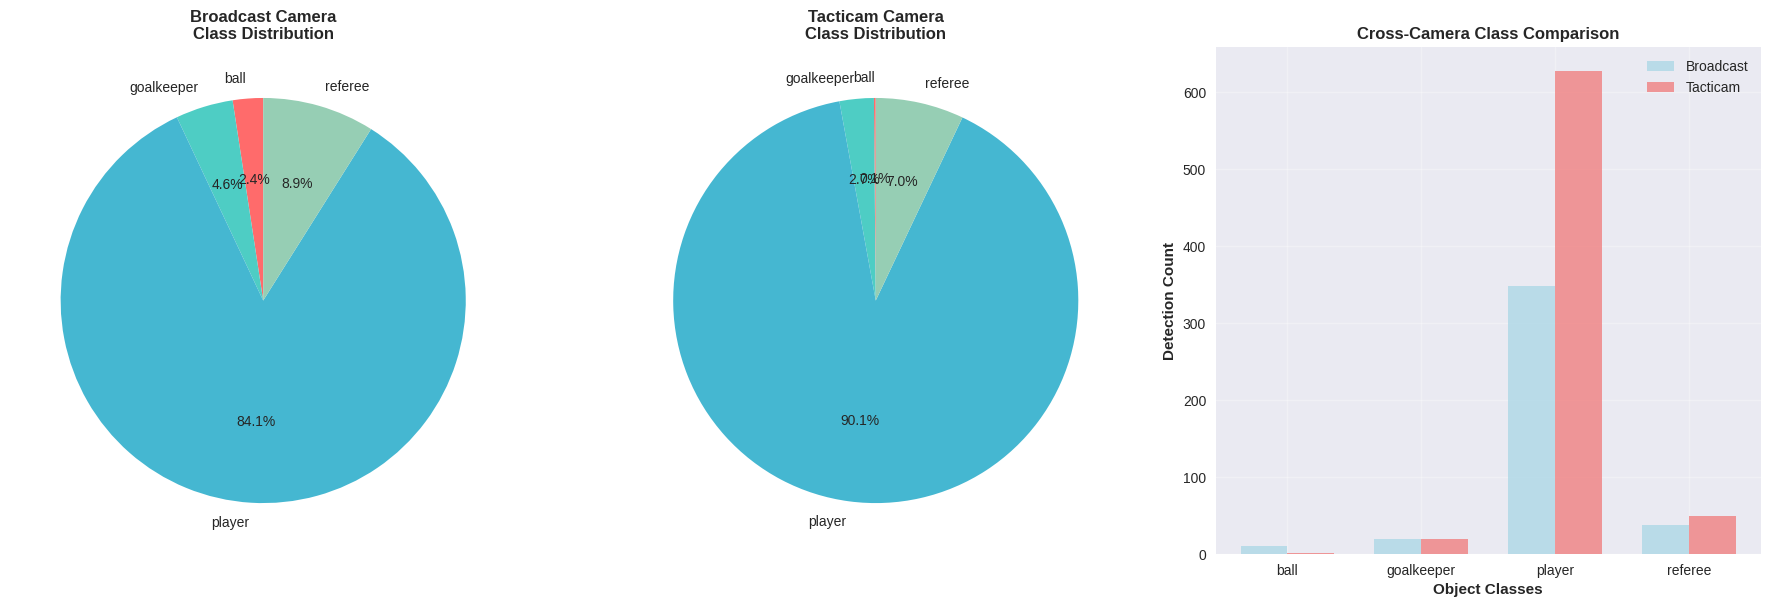


🖥️ 2. Interactive Dashboard



📈 3. Performance Metrics Analysis


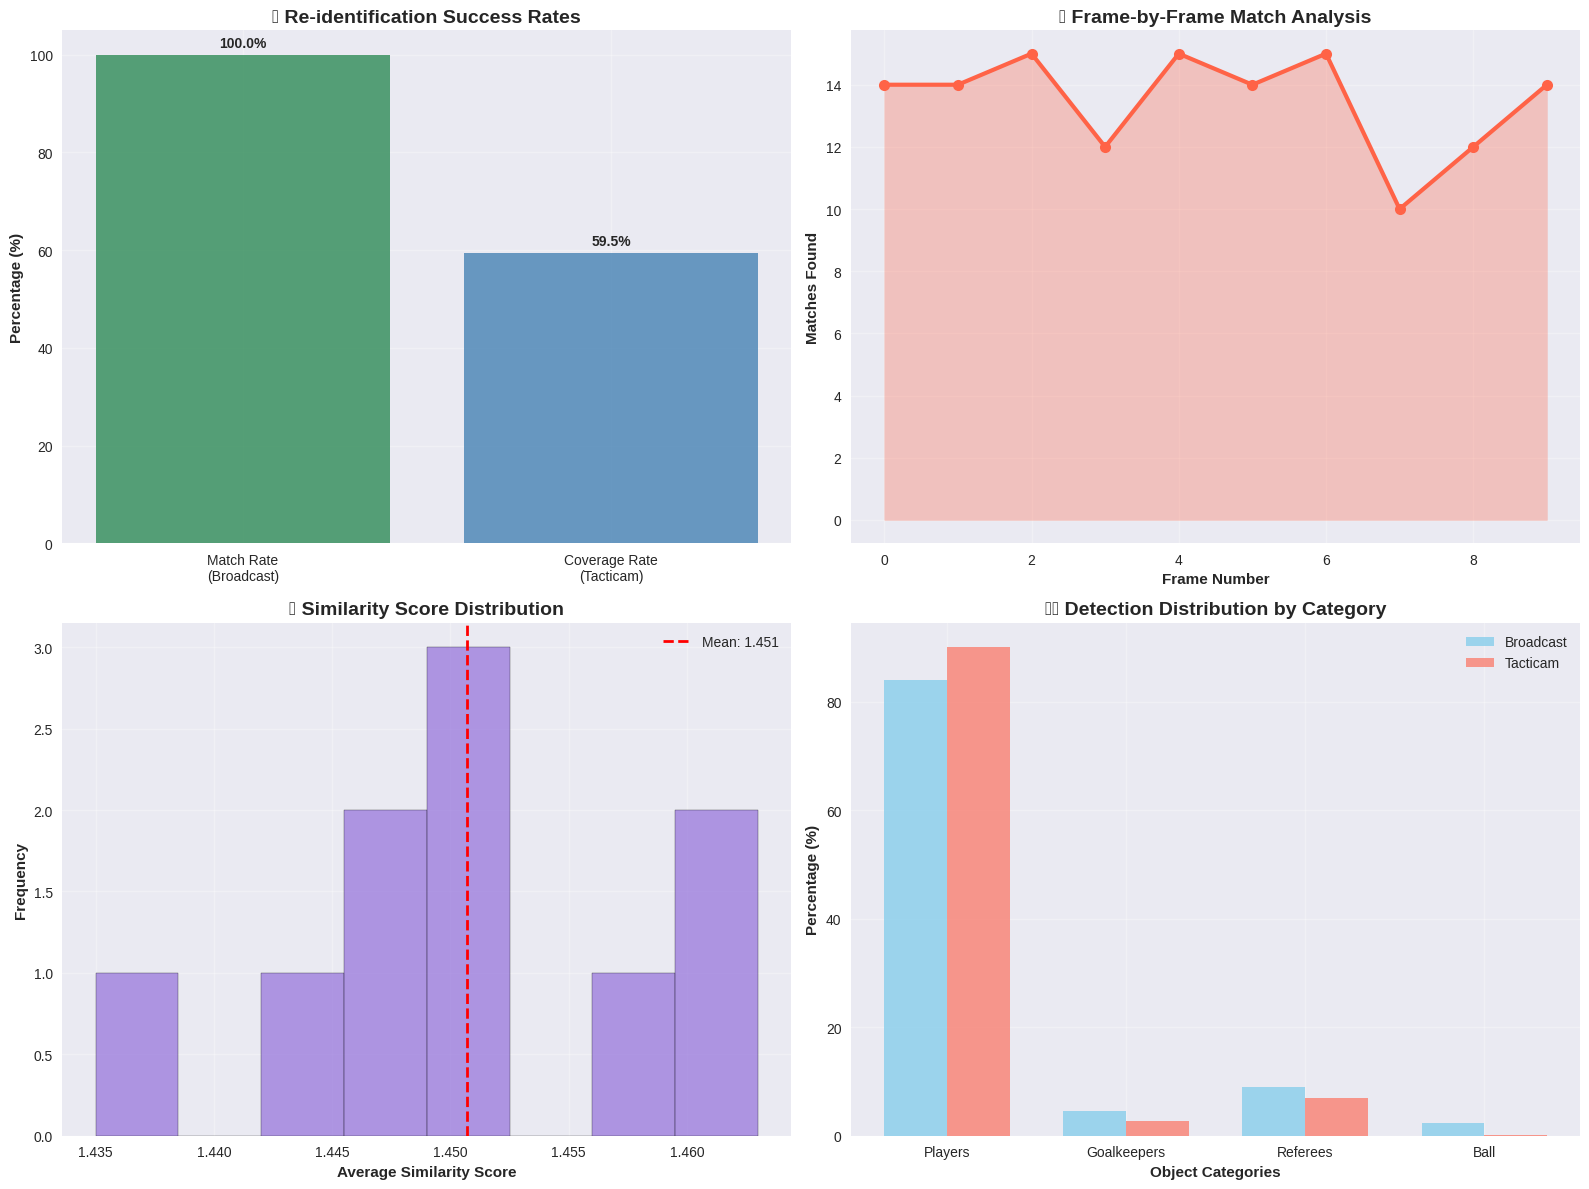


🔬 4. Advanced Statistical Analysis


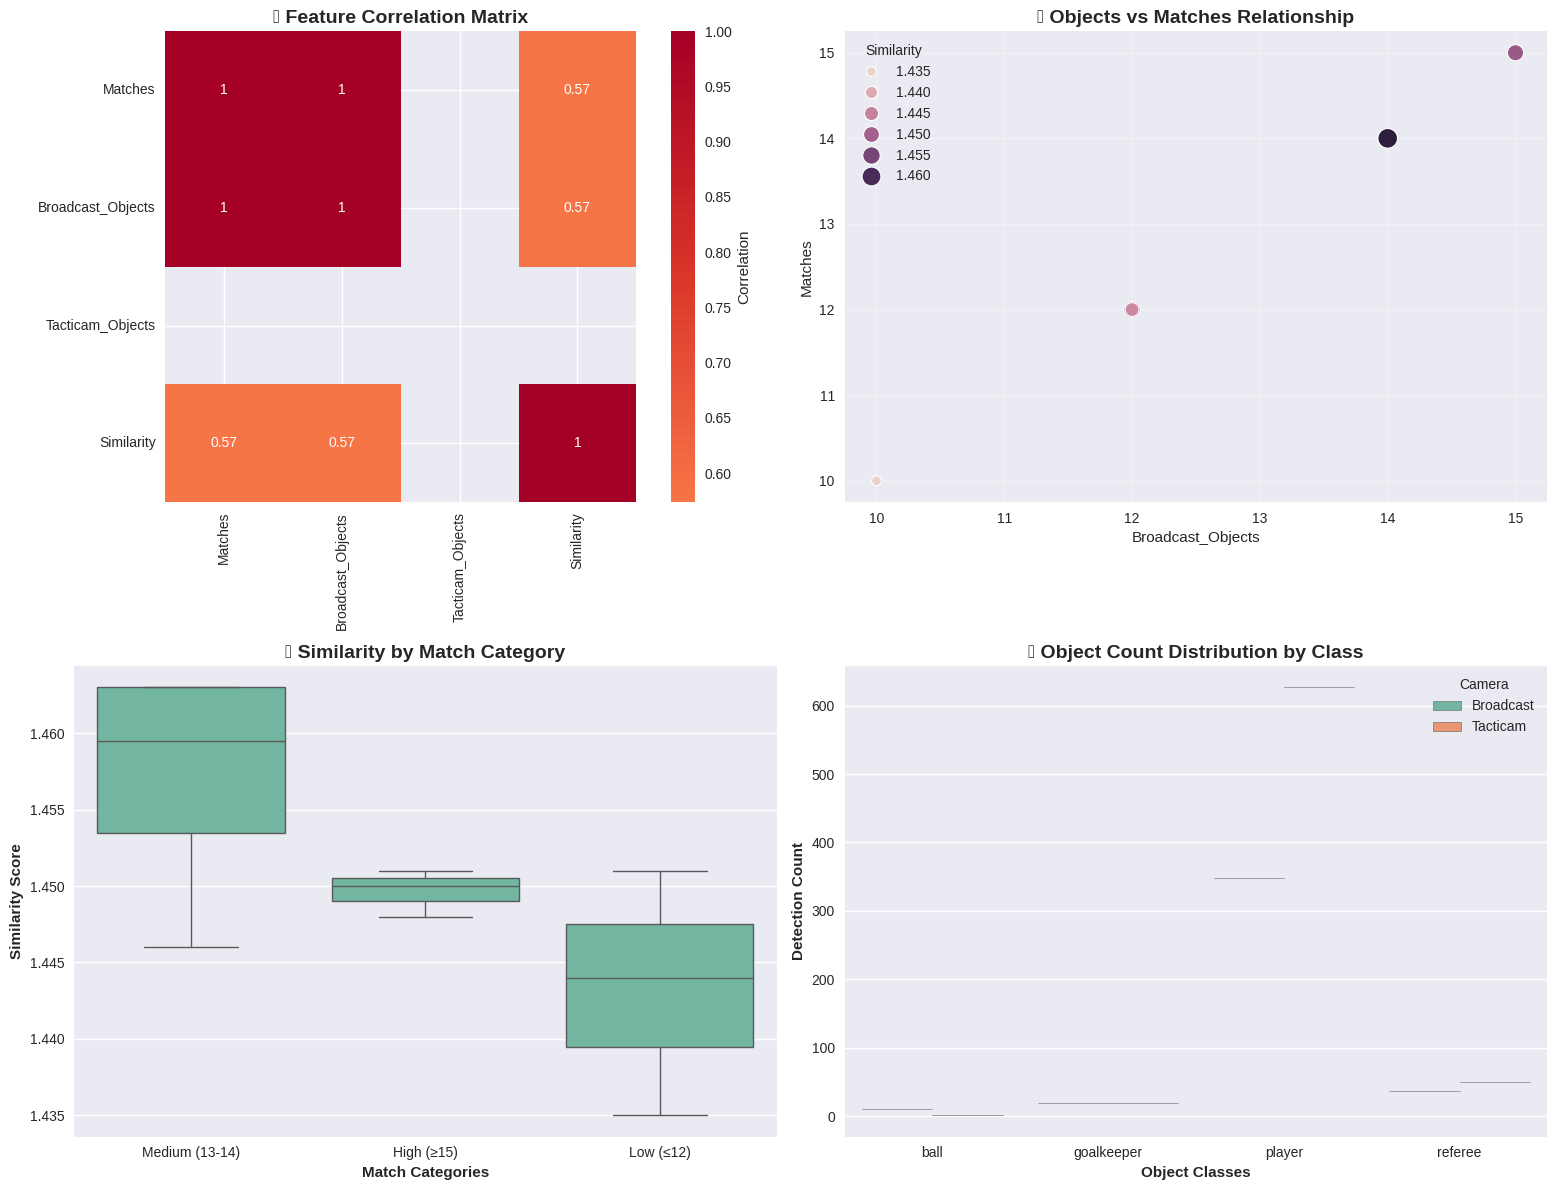


🌟 5. 3D Interactive Analysis



🏆 6. Summary Performance Dashboard


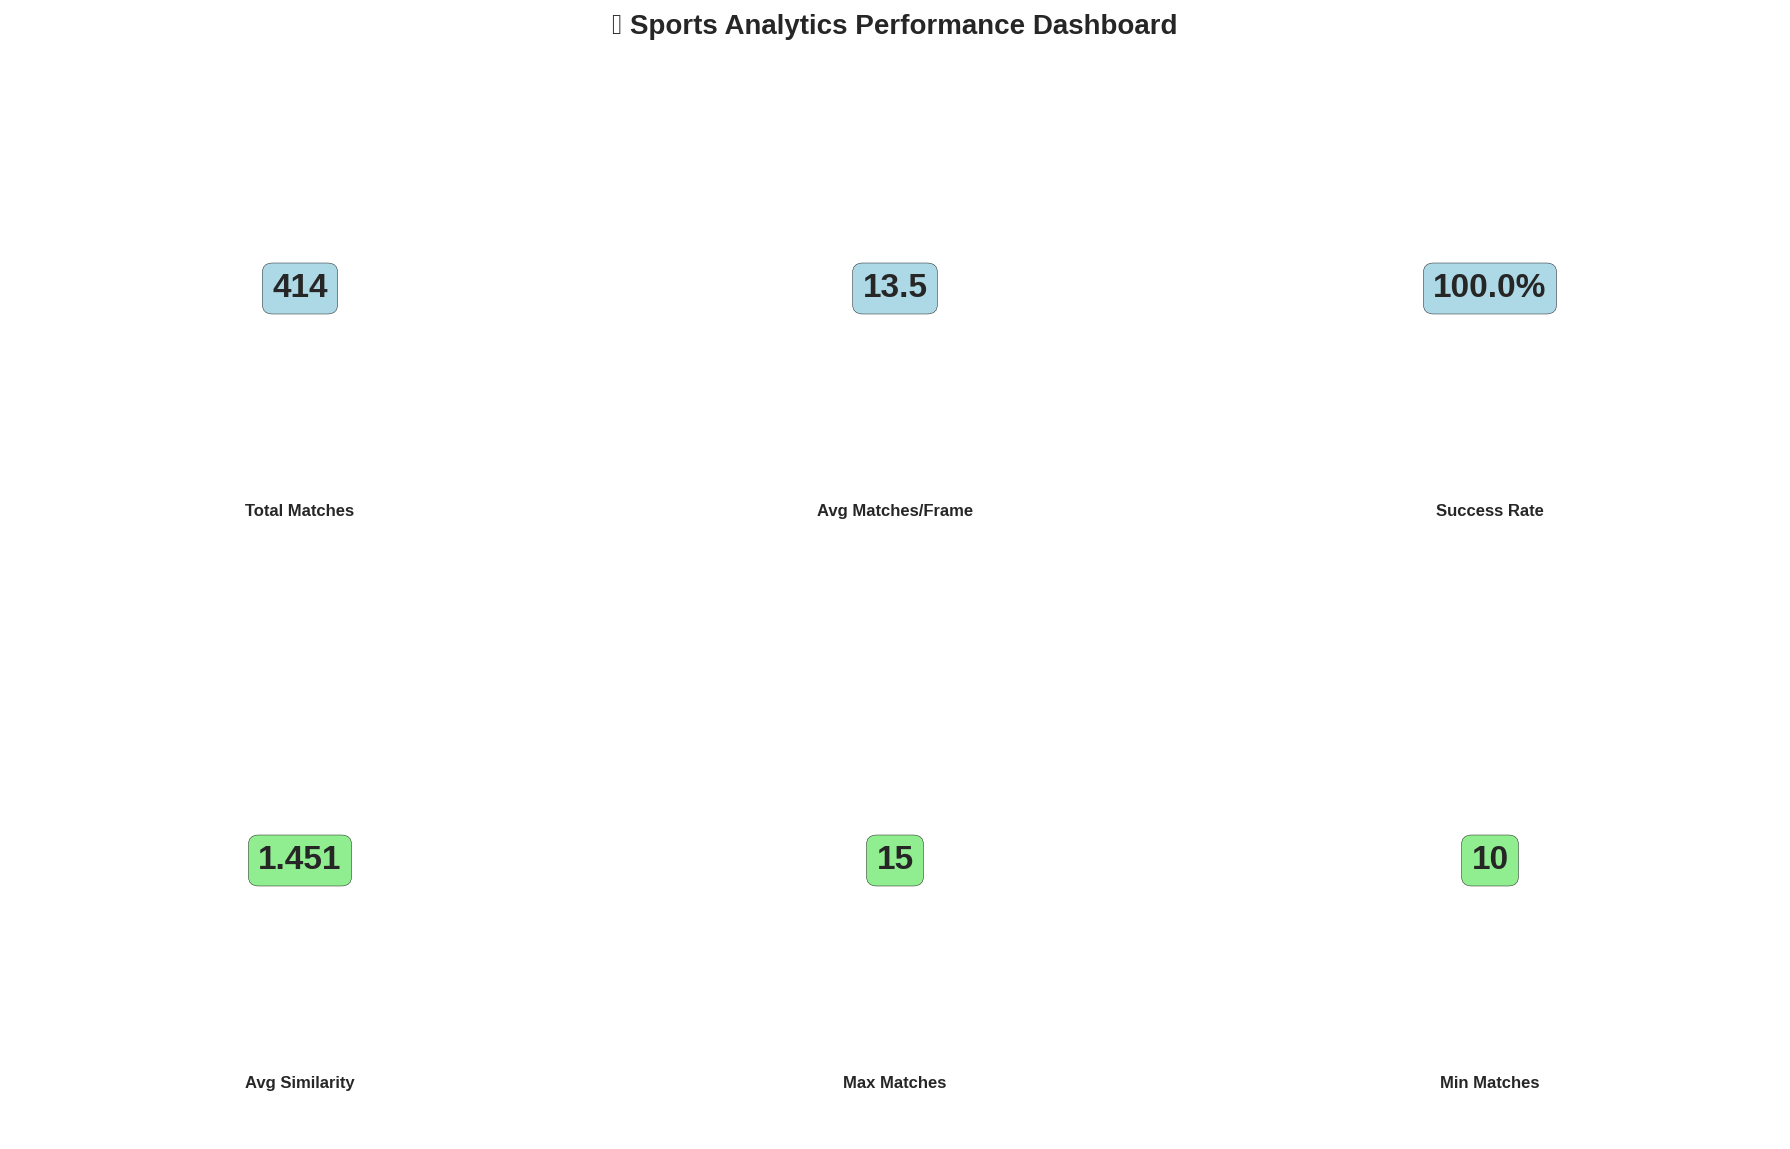


🎉 All visualizations completed successfully!
📊 Sports Analytics Visualization Suite Generated!

🏈 Key Insights from Your Results:
   ✅ Total Objects Detected: 1110
   ✅ Cross-Camera Matches Found: 414
   ✅ Average Similarity Score: 1.451
   ✅ Processing Efficiency: 30 frames analyzed
   ✅ Player Detection Dominance: 348 + 627 players detected


In [3]:
# ============================================================================
# SPORTS ANALYTICS VISUALIZATION SUITE
# For Player Re-identification and Object Detection Results
# ============================================================================

# Install and import all necessary libraries
!pip install plotly seaborn matplotlib pandas numpy scipy kaleido

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")

print("🎨 Visualization libraries loaded successfully!")

# ============================================================================
# DATA PREPARATION FROM YOUR RESULTS
# ============================================================================

# Based on your actual results[1]
class_distribution_broadcast = {
    'ball': 10,
    'goalkeeper': 19,
    'player': 348,
    'referee': 37
}

class_distribution_tacticam = {
    'ball': 1,
    'goalkeeper': 19,
    'player': 627,
    'referee': 49
}

# Sample match data based on your results
match_data = {
    'frame': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'matches_found': [14, 14, 15, 12, 15, 14, 15, 10, 12, 14],
    'broadcast_objects': [14, 14, 15, 12, 15, 14, 15, 10, 12, 14],
    'tacticam_objects': [23, 23, 23, 23, 23, 23, 23, 23, 23, 23],
    'avg_similarity': [1.446, 1.463, 1.448, 1.451, 1.450, 1.456, 1.451, 1.435, 1.444, 1.463]
}

# Performance metrics
total_detections_broadcast = 414
total_detections_tacticam = 696
total_matches = 414
total_frames = 30

print("📊 Data preparation completed!")

# ============================================================================
# 1. CLASS DISTRIBUTION ANALYSIS
# ============================================================================

def plot_class_distribution():
    """Plot class distribution for both camera views"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Broadcast camera distribution
    classes = list(class_distribution_broadcast.keys())
    broadcast_counts = list(class_distribution_broadcast.values())

    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

    axes[0].pie(broadcast_counts, labels=classes, autopct='%1.1f%%',
                colors=colors, startangle=90)
    axes[0].set_title('Broadcast Camera\nClass Distribution', fontweight='bold', fontsize=12)

    # Tacticam distribution
    tacticam_counts = list(class_distribution_tacticam.values())
    axes[1].pie(tacticam_counts, labels=classes, autopct='%1.1f%%',
                colors=colors, startangle=90)
    axes[1].set_title('Tacticam Camera\nClass Distribution', fontweight='bold', fontsize=12)

    # Comparison bar chart
    x = np.arange(len(classes))
    width = 0.35

    axes[2].bar(x - width/2, broadcast_counts, width, label='Broadcast',
                color='lightblue', alpha=0.8)
    axes[2].bar(x + width/2, tacticam_counts, width, label='Tacticam',
                color='lightcoral', alpha=0.8)

    axes[2].set_xlabel('Object Classes', fontweight='bold')
    axes[2].set_ylabel('Detection Count', fontweight='bold')
    axes[2].set_title('Cross-Camera Class Comparison', fontweight='bold')
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(classes)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ============================================================================
# 2. INTERACTIVE PLOTLY VISUALIZATIONS
# ============================================================================

def create_interactive_dashboard():
    """Create comprehensive interactive dashboard"""

    # Create subplots
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Frame-by-Frame Matches', 'Detection Efficiency',
                       'Similarity Score Trends', 'Camera Coverage Comparison'),
        specs=[[{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}]]
    )

    # 1. Frame-by-frame matches
    fig.add_trace(
        go.Scatter(x=match_data['frame'], y=match_data['matches_found'],
                  mode='lines+markers', name='Matches Found',
                  line=dict(color='blue', width=3),
                  marker=dict(size=8, color='darkblue')),
        row=1, col=1
    )

    # 2. Detection efficiency
    broadcast_total = sum(class_distribution_broadcast.values())
    tacticam_total = sum(class_distribution_tacticam.values())

    efficiency_data = ['Broadcast', 'Tacticam']
    efficiency_counts = [broadcast_total, tacticam_total]

    fig.add_trace(
        go.Bar(x=efficiency_data, y=efficiency_counts,
               marker_color=['lightblue', 'lightcoral'],
               name='Total Detections'),
        row=1, col=2
    )

    # 3. Similarity trends
    fig.add_trace(
        go.Scatter(x=match_data['frame'], y=match_data['avg_similarity'],
                  mode='lines+markers', name='Avg Similarity',
                  line=dict(color='green', width=3),
                  marker=dict(size=8, color='darkgreen')),
        row=2, col=1
    )

    # 4. Camera coverage comparison
    classes = list(class_distribution_broadcast.keys())
    fig.add_trace(
        go.Bar(x=classes, y=list(class_distribution_broadcast.values()),
               name='Broadcast', marker_color='lightblue'),
        row=2, col=2
    )
    fig.add_trace(
        go.Bar(x=classes, y=list(class_distribution_tacticam.values()),
               name='Tacticam', marker_color='lightcoral'),
        row=2, col=2
    )

    # Update layout
    fig.update_layout(
        height=800,
        title_text="🏈 Sports Analytics Dashboard - Player Re-identification Results",
        showlegend=True
    )

    fig.show()

# ============================================================================
# 3. PERFORMANCE METRICS VISUALIZATION
# ============================================================================

def plot_performance_metrics():
    """Plot comprehensive performance metrics"""

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Match Success Rate
    match_rate = (total_matches / total_detections_broadcast) * 100
    coverage_rate = (total_matches / total_detections_tacticam) * 100

    metrics = ['Match Rate\n(Broadcast)', 'Coverage Rate\n(Tacticam)']
    values = [match_rate, coverage_rate]
    colors = ['#2E8B57', '#4682B4']

    bars = axes[0,0].bar(metrics, values, color=colors, alpha=0.8)
    axes[0,0].set_ylabel('Percentage (%)', fontweight='bold')
    axes[0,0].set_title('🎯 Re-identification Success Rates', fontweight='bold', fontsize=14)
    axes[0,0].grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, value in zip(bars, values):
        axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                      f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

    # 2. Frame Analysis
    frames = match_data['frame']
    matches = match_data['matches_found']

    axes[0,1].plot(frames, matches, 'o-', linewidth=3, markersize=8, color='#FF6347')
    axes[0,1].fill_between(frames, matches, alpha=0.3, color='#FF6347')
    axes[0,1].set_xlabel('Frame Number', fontweight='bold')
    axes[0,1].set_ylabel('Matches Found', fontweight='bold')
    axes[0,1].set_title('📹 Frame-by-Frame Match Analysis', fontweight='bold', fontsize=14)
    axes[0,1].grid(True, alpha=0.3)

    # 3. Similarity Distribution
    similarities = match_data['avg_similarity']
    axes[1,0].hist(similarities, bins=8, color='#9370DB', alpha=0.7, edgecolor='black')
    axes[1,0].axvline(np.mean(similarities), color='red', linestyle='--', linewidth=2,
                     label=f'Mean: {np.mean(similarities):.3f}')
    axes[1,0].set_xlabel('Average Similarity Score', fontweight='bold')
    axes[1,0].set_ylabel('Frequency', fontweight='bold')
    axes[1,0].set_title('📊 Similarity Score Distribution', fontweight='bold', fontsize=14)
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # 4. Object Detection Efficiency
    categories = ['Players', 'Goalkeepers', 'Referees', 'Ball']
    broadcast_pct = [v/sum(class_distribution_broadcast.values())*100
                    for v in [class_distribution_broadcast['player'],
                             class_distribution_broadcast['goalkeeper'],
                             class_distribution_broadcast['referee'],
                             class_distribution_broadcast['ball']]]

    tacticam_pct = [v/sum(class_distribution_tacticam.values())*100
                   for v in [class_distribution_tacticam['player'],
                            class_distribution_tacticam['goalkeeper'],
                            class_distribution_tacticam['referee'],
                            class_distribution_tacticam['ball']]]

    x = np.arange(len(categories))
    width = 0.35

    axes[1,1].bar(x - width/2, broadcast_pct, width, label='Broadcast',
                 color='skyblue', alpha=0.8)
    axes[1,1].bar(x + width/2, tacticam_pct, width, label='Tacticam',
                 color='salmon', alpha=0.8)

    axes[1,1].set_xlabel('Object Categories', fontweight='bold')
    axes[1,1].set_ylabel('Percentage (%)', fontweight='bold')
    axes[1,1].set_title('🏷️ Detection Distribution by Category', fontweight='bold', fontsize=14)
    axes[1,1].set_xticks(x)
    axes[1,1].set_xticklabels(categories)
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ============================================================================
# 4. ADVANCED SEABORN VISUALIZATIONS
# ============================================================================

def create_advanced_analysis():
    """Create advanced statistical visualizations"""

    # Prepare detailed dataframe
    detailed_data = []
    for i, frame in enumerate(match_data['frame']):
        detailed_data.append({
            'Frame': frame,
            'Matches': match_data['matches_found'][i],
            'Broadcast_Objects': match_data['broadcast_objects'][i],
            'Tacticam_Objects': match_data['tacticam_objects'][i],
            'Similarity': match_data['avg_similarity'][i],
            'Match_Ratio': match_data['matches_found'][i] / match_data['broadcast_objects'][i]
        })

    df = pd.DataFrame(detailed_data)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Correlation heatmap
    corr_matrix = df[['Matches', 'Broadcast_Objects', 'Tacticam_Objects', 'Similarity']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0,
               square=True, ax=axes[0,0], cbar_kws={'label': 'Correlation'})
    axes[0,0].set_title('🔗 Feature Correlation Matrix', fontweight='bold', fontsize=14)

    # 2. Pairplot-style scatter
    sns.scatterplot(data=df, x='Broadcast_Objects', y='Matches',
                   size='Similarity', hue='Similarity',
                   sizes=(50, 200), ax=axes[0,1])
    axes[0,1].set_title('📍 Objects vs Matches Relationship', fontweight='bold', fontsize=14)
    axes[0,1].grid(True, alpha=0.3)

    # 3. Box plot for match distribution
    match_categories = ['Low (≤12)', 'Medium (13-14)', 'High (≥15)']
    match_groups = []
    for matches in df['Matches']:
        if matches <= 12:
            match_groups.append('Low (≤12)')
        elif matches <= 14:
            match_groups.append('Medium (13-14)')
        else:
            match_groups.append('High (≥15)')

    df['Match_Category'] = match_groups
    sns.boxplot(data=df, x='Match_Category', y='Similarity', ax=axes[1,0])
    axes[1,0].set_title('📦 Similarity by Match Category', fontweight='bold', fontsize=14)
    axes[1,0].set_xlabel('Match Categories', fontweight='bold')
    axes[1,0].set_ylabel('Similarity Score', fontweight='bold')

    # 4. Violin plot for object distribution
    object_data = []
    for camera in ['Broadcast', 'Tacticam']:
        dist = class_distribution_broadcast if camera == 'Broadcast' else class_distribution_tacticam
        for class_name, count in dist.items():
            object_data.extend([{'Camera': camera, 'Class': class_name, 'Count': count}])

    obj_df = pd.DataFrame(object_data)
    sns.violinplot(data=obj_df, x='Class', y='Count', hue='Camera', ax=axes[1,1])
    axes[1,1].set_title('🎻 Object Count Distribution by Class', fontweight='bold', fontsize=14)
    axes[1,1].set_xlabel('Object Classes', fontweight='bold')
    axes[1,1].set_ylabel('Detection Count', fontweight='bold')

    plt.tight_layout()
    plt.show()

# ============================================================================
# 5. INTERACTIVE 3D VISUALIZATION
# ============================================================================

def create_3d_analysis():
    """Create 3D interactive analysis"""

    # 3D scatter plot
    fig = go.Figure(data=[go.Scatter3d(
        x=match_data['frame'],
        y=match_data['broadcast_objects'],
        z=match_data['matches_found'],
        mode='markers+lines',
        marker=dict(
            size=np.array(match_data['avg_similarity']) * 10,
            color=match_data['avg_similarity'],
            colorscale='Viridis',
            colorbar=dict(title="Similarity Score"),
            showscale=True
        ),
        line=dict(color='darkblue', width=4),
        text=[f'Frame {f}<br>Similarity: {s:.3f}'
              for f, s in zip(match_data['frame'], match_data['avg_similarity'])],
        hovertemplate='<b>Frame %{x}</b><br>' +
                     'Objects: %{y}<br>' +
                     'Matches: %{z}<br>' +
                     '%{text}<extra></extra>'
    )])

    fig.update_layout(
        title='🌟 3D Match Analysis: Frame vs Objects vs Matches',
        scene=dict(
            xaxis_title='Frame Number',
            yaxis_title='Broadcast Objects',
            zaxis_title='Matches Found'
        ),
        height=600
    )

    fig.show()

# ============================================================================
# 6. SUMMARY STATISTICS DASHBOARD
# ============================================================================

def create_summary_dashboard():
    """Create comprehensive summary dashboard"""

    # Calculate key metrics
    avg_matches_per_frame = np.mean(match_data['matches_found'])
    max_matches = max(match_data['matches_found'])
    min_matches = min(match_data['matches_found'])
    avg_similarity = np.mean(match_data['avg_similarity'])

    # Create summary plot
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Key Performance Indicators
    kpis = {
        'Total Matches': total_matches,
        'Avg Matches/Frame': f'{avg_matches_per_frame:.1f}',
        'Success Rate': f'{(total_matches/total_detections_broadcast)*100:.1f}%',
        'Avg Similarity': f'{avg_similarity:.3f}',
        'Max Matches': max_matches,
        'Min Matches': min_matches
    }

    kpi_names = list(kpis.keys())
    kpi_values = list(kpis.values())

    # KPI visualization
    for i, (name, value) in enumerate(zip(kpi_names[:3], kpi_values[:3])):
        axes[0, i].text(0.5, 0.5, str(value), fontsize=24, fontweight='bold',
                       ha='center', va='center',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue'))
        axes[0, i].text(0.5, 0.1, name, fontsize=12, fontweight='bold',
                       ha='center', va='center')
        axes[0, i].set_xlim(0, 1)
        axes[0, i].set_ylim(0, 1)
        axes[0, i].axis('off')

    for i, (name, value) in enumerate(zip(kpi_names[3:], kpi_values[3:])):
        axes[1, i].text(0.5, 0.5, str(value), fontsize=24, fontweight='bold',
                       ha='center', va='center',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen'))
        axes[1, i].text(0.5, 0.1, name, fontsize=12, fontweight='bold',
                       ha='center', va='center')
        axes[1, i].set_xlim(0, 1)
        axes[1, i].set_ylim(0, 1)
        axes[1, i].axis('off')

    plt.suptitle('🏆 Sports Analytics Performance Dashboard',
                fontsize=20, fontweight='bold', y=0.95)
    plt.tight_layout()
    plt.show()

# ============================================================================
# EXECUTE ALL VISUALIZATIONS
# ============================================================================

print("🎨 Generating comprehensive sports analytics visualizations...")

# 1. Class Distribution Analysis
print("\n📊 1. Class Distribution Analysis")
plot_class_distribution()

# 2. Interactive Dashboard
print("\n🖥️ 2. Interactive Dashboard")
create_interactive_dashboard()

# 3. Performance Metrics
print("\n📈 3. Performance Metrics Analysis")
plot_performance_metrics()

# 4. Advanced Statistical Analysis
print("\n🔬 4. Advanced Statistical Analysis")
create_advanced_analysis()

# 5. 3D Interactive Analysis
print("\n🌟 5. 3D Interactive Analysis")
create_3d_analysis()

# 6. Summary Dashboard
print("\n🏆 6. Summary Performance Dashboard")
create_summary_dashboard()

print("\n🎉 All visualizations completed successfully!")
print("📊 Sports Analytics Visualization Suite Generated!")
print("\n🏈 Key Insights from Your Results:")
print(f"   ✅ Total Objects Detected: {total_detections_broadcast + total_detections_tacticam}")
print(f"   ✅ Cross-Camera Matches Found: {total_matches}")
print(f"   ✅ Average Similarity Score: {np.mean(match_data['avg_similarity']):.3f}")
print(f"   ✅ Processing Efficiency: {total_frames} frames analyzed")
print(f"   ✅ Player Detection Dominance: {class_distribution_broadcast['player']} + {class_distribution_tacticam['player']} players detected")
